In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
import re
from geopy.distance import vincenty
import matplotlib.dates as mdts
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split

In [14]:
def filter_blk_desc(path):
    dest_path = path + '/inc/blkg'
    bound_re = re.compile(r"(IF [E,N,S,W]B)")
    m_path = path + '/det'
    pth = Path(m_path)
    for child in pth.iterdir():
        incdnt_det_file_name = m_path + '/' + child.name
        det_month = pd.read_csv(incdnt_det_file_name, parse_dates=['Timestamp'])
        blkg_desc = det_month[det_month.apply(lambda row: ('NOT BLK' not in row.Desc) & ((' BLKG' in row.Desc) | (' BLKD' in row.Desc) | (' BLKING' in row.Desc) | (' BLKG' in row.Desc)) & ((' ENTIR' in row.Desc) | (' LN' in row.Desc)) & (('IF LN' not in row.Desc)) & (not bound_re.search(row.Desc)), axis=1)]
        blkg_desc.drop_duplicates(subset=['ID'], keep='first', inplace=True)
        blkg_desc.to_csv(dest_path + '/' + child.name[:-4] + '.csv', index=False)

In [17]:
filter_blk_desc('../data/PeMS/Incidents/work_folder/Months/Jun/')

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [21]:
dir_list = [
            '../data/PeMS/Incidents/work_folder/Months/Jan/',
            '../data/PeMS/Incidents/work_folder/Months/Feb/',
            '../data/PeMS/Incidents/work_folder/Months/Mar/',
            '../data/PeMS/Incidents/work_folder/Months/Apr/',
           '../data/PeMS/Incidents/work_folder/Months/May/',
           '../data/PeMS/Incidents/work_folder/Months/Jun/',
           '../data/PeMS/Incidents/work_folder/Months/Jul/',
           '../data/PeMS/Incidents/work_folder/Months/Aug/',
           '../data/PeMS/Incidents/work_folder/Months/Sep/',
           '../data/PeMS/Incidents/work_folder/Months/Oct/',
           '../data/PeMS/Incidents/work_folder/Months/Nov/',
           '../data/PeMS/Incidents/work_folder/Months/Dec/']
for a_dir in dir_list:
    filter_blk_desc(a_dir)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [23]:
dir_list = [
            '../data/PeMS/Incidents/work_folder/Months/Jan/'
]
for a_dir in dir_list:
    filter_blk_desc(a_dir)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [3]:
def get_next_downstream_station(stations, incident, correction=0):
    fwy_no = incident.Freeway
    fwy_dir = incident.Freeway_direction
    lon = incident.Longitude
    lat = incident.Latitude
    candidates = stations[(stations['Fwy']==fwy_no) & (stations['Dir']==fwy_dir)].copy()
    if fwy_dir == 'S':
        candidates['Distance'] = lat - candidates['Latitude']
        cond1 = candidates['Latitude'] < lat - correction
    elif fwy_dir == 'N':
        candidates['Distance'] = candidates['Latitude'] - lat
        cond1 = candidates['Latitude'] > lat + correction
    elif fwy_dir == 'W':
        candidates['Distance'] = lon - candidates['Longitude']
        cond1 = candidates['Longitude'] < lon - correction
    else : # fwy_dir == 'E':
        candidates['Distance'] = candidates['Longitude'] - lon
        cond1 = candidates['Longitude'] > lon + correction
    cond2 = (np.abs(candidates['Distance'])<0.025)
#     print(incidents[incidents['IncidentID']==incidentID].iloc[0])
    return candidates[cond1 & cond2 & (candidates['Distance'] > 0)].sort_values(['Distance']).reset_index(drop=True)

In [4]:
def get_next_upstream_station(stations, incident, correction=0):
    fwy_no = incident.Freeway
    fwy_dir = incident.Freeway_direction
    lon = incident.Longitude
    lat = incident.Latitude
    candidates = stations[(stations['Fwy']==fwy_no) & (stations['Dir']==fwy_dir)].copy()
    if fwy_dir == 'N':
        candidates['Distance'] = lat - candidates['Latitude']
        cond1 = candidates['Latitude'] < lat - correction
    elif fwy_dir == 'S':
        candidates['Distance'] = candidates['Latitude'] - lat
        cond1 = candidates['Latitude'] > lat + correction
    elif fwy_dir == 'E':
        candidates['Distance'] = lon - candidates['Longitude']
        cond1 = candidates['Longitude'] < lon - correction
    else : # fwy_dir == 'E':
        candidates['Distance'] = candidates['Longitude'] - lon
        cond1 = candidates['Longitude'] > lon + correction
    cond2 = (np.abs(candidates['Distance'])<0.025)
#     print(incidents[incidents['IncidentID']==incidentID].iloc[0])
    return candidates[cond1 & cond2 & (candidates['Distance'] > 0)].sort_values(['Distance']).reset_index(drop=True)

In [5]:
def get_next_wrapper(inc, func, stations):
    nxt = func(stations, inc)
    return nxt.iloc[0].ID if nxt.size>0 else 0 

In [6]:
def obtain_time_series(an_inc, full_series, chrcteristic='Avg Occupancy'):
    st = an_inc.Prev
    test = full_series[(full_series.Station==st) &  (full_series.Timestamp >= an_inc.Timestamp-dt.timedelta(minutes=40)) & (full_series.Timestamp < an_inc.Timestamp+dt.timedelta(minutes=20))].copy()
    return test[chrcteristic].reset_index(drop=True).add_prefix(chrcteristic + '_')
#     test = test.reset_index(drop=True).reset_index()
#     return test.pivot(index='Station', columns='index', values='Avg Occupancy').reset_index().drop(columns=["Station"]).loc[0]

In [13]:
def create_accident_windows(path):
    path_inc = path + '/inc/light'
    pth = Path(path_inc)
    srs_path = path + '/series/smoothed'
    s_pth = Path(srs_path)
    cols = ['IncidentID', 'Timestamp', 'Latitude', 'Longitude', 'Freeway', 'Freeway_direction']
    result = pd.DataFrame()
    stations_pth = path + '/stations'
    st_pth = Path(stations_pth)
    blk_path = path + '/inc/blkg'
    blkg_desc = pd.read_csv(blk_path + '/' + sorted(Path(blk_path).iterdir())[0].name, parse_dates=['Timestamp'])
    dest_path = path + '/result'
    
    for i,child in enumerate(sorted(pth.iterdir())):
        incdnt_file_name = path_inc + '/' + child.name
        inc_file = pd.read_csv(incdnt_file_name, parse_dates=['Timestamp'], dtype={'IncidentID':np.int64,'Latitude':np.float64,'Longitude':np.float64,'Freeway':np.int32, 'Freeway_direction':object})[cols]
        inc_file.drop(index=inc_file[~inc_file.IncidentID.isin(blkg_desc.ID)].index, inplace=True)
        srs_f_name = srs_path + '/' + sorted(s_pth.iterdir())[i].name
        srs = pd.read_csv(srs_f_name, parse_dates=['Timestamp'])
        st_active_file_name = stations_pth + '/' + sorted(st_pth.iterdir())[0].name
        st_active = pd.read_csv(st_active_file_name).drop(columns=['User_ID_1', 'User_ID_2', 'User_ID_3', 'User_ID_4'])
        st_active.drop(index=st_active[~st_active.ID.isin(srs.Station.unique())].index, inplace=True)
        srs = srs.merge(st_active[['ID', 'Lanes']], how='left', left_on='Station', right_on='ID')
        srs['Total Flow'] = srs['Total Flow']/srs['Lanes']
        inc_file['Prev'] = inc_file.apply(get_next_wrapper, axis=1, args=(get_next_upstream_station, st_active))
        inc_file.drop(index=inc_file[inc_file.Prev==0].index, inplace=True)
        inc_file.drop(index=inc_file[(inc_file.Timestamp.dt.time<dt.time(hour=1)) | (inc_file.Timestamp.dt.hour>=23)].index, inplace=True)
        windows = inc_file.apply(obtain_time_series, axis=1, args=[srs, 'Avg Occupancy'])
        inc_file = pd.concat((inc_file, windows), axis=1)
        windows = inc_file.apply(obtain_time_series, axis=1, args=[srs, 'Total Flow'])
        inc_file = pd.concat((inc_file, windows), axis=1)
        windows = inc_file.apply(obtain_time_series, axis=1, args=[srs, 'Avg Speed'])
        inc_file = pd.concat((inc_file, windows), axis=1)
        
#         break
        result = pd.concat((result, inc_file), axis=0)
    result.to_csv(dest_path + '/accident_windows.csv', index=False)
    return result    

In [19]:
accdnt_windows = create_accident_windows('../data/PeMS/Incidents/work_folder/Months/Jun')

In [22]:
dir_list = [
            '../data/PeMS/Incidents/work_folder/Months/Jan/',
            '../data/PeMS/Incidents/work_folder/Months/Feb/',
            '../data/PeMS/Incidents/work_folder/Months/Mar/',
            '../data/PeMS/Incidents/work_folder/Months/Apr/',
           '../data/PeMS/Incidents/work_folder/Months/May/',
           '../data/PeMS/Incidents/work_folder/Months/Jun/',
           '../data/PeMS/Incidents/work_folder/Months/Jul/',
           '../data/PeMS/Incidents/work_folder/Months/Aug/',
           '../data/PeMS/Incidents/work_folder/Months/Sep/',
           '../data/PeMS/Incidents/work_folder/Months/Oct/',
           '../data/PeMS/Incidents/work_folder/Months/Nov/',
           '../data/PeMS/Incidents/work_folder/Months/Dec/']
for a_dir in dir_list:
    accdnt_windows = create_accident_windows(a_dir)

In [31]:
accdnt_windows = pd.DataFrame()
dir_list = [
            '../data/PeMS/Incidents/work_folder/Months/Jan/result/accident_windows.csv',
            '../data/PeMS/Incidents/work_folder/Months/Feb/result/accident_windows.csv',
            '../data/PeMS/Incidents/work_folder/Months/Mar/result/accident_windows.csv',
            '../data/PeMS/Incidents/work_folder/Months/Apr/result/accident_windows.csv',
           '../data/PeMS/Incidents/work_folder/Months/May/result/accident_windows.csv',
           '../data/PeMS/Incidents/work_folder/Months/Jun/result/accident_windows.csv',
           '../data/PeMS/Incidents/work_folder/Months/Jul/result/accident_windows.csv',
           '../data/PeMS/Incidents/work_folder/Months/Aug/result/accident_windows.csv',
           '../data/PeMS/Incidents/work_folder/Months/Sep/result/accident_windows.csv',
           '../data/PeMS/Incidents/work_folder/Months/Oct/result/accident_windows.csv',
           '../data/PeMS/Incidents/work_folder/Months/Nov/result/accident_windows.csv',
           '../data/PeMS/Incidents/work_folder/Months/Dec/result/accident_windows.csv']
for a_file in dir_list:
    accdnt_windows = pd.concat((accdnt_windows, pd.read_csv(a_file)))

In [56]:
col_order = accdnt_windows.columns[[26,30,27,28,24,25,29,0,1,4,5,6,7,8,9,10,11,2,3,31,32,35,36,37,38,39,40,41,42,33,34,12,13,16,17,18,19,20,21,22,23,14,15]]

In [63]:
col_order = ['IncidentID', 'Timestamp', 'Latitude', 'Longitude', 'Freeway',
       'Freeway_direction', 'Prev', 'Avg Occupancy_0', 'Avg Occupancy_1',
       'Avg Occupancy_2', 'Avg Occupancy_3', 'Avg Occupancy_4',
       'Avg Occupancy_5', 'Avg Occupancy_6', 'Avg Occupancy_7',
       'Avg Occupancy_8', 'Avg Occupancy_9', 'Avg Occupancy_10',
       'Avg Occupancy_11', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11']

In [64]:
accdnt_windows = accdnt_windows[col_order]

In [66]:
accdnt_windows.to_csv('../data/PeMS/Incidents/work_folder/year_accdnt_wndw.csv', index=False)

In [145]:
def plot_window(data, chrct = 'Total Flow'):
    
    cols = [col for col in data.index if chrct in col]
    data[cols].plot()
    plt.grid()
    plt.show()

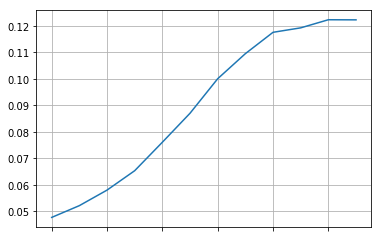

In [197]:
plot_window(accdnt_windows.iloc[66], 'Occupancy')

In [69]:
st = pd.read_csv('../data/PeMS/Incidents/work_folder/Months/Apr/stations/d07_text_meta_2017_04_29.csv')

In [82]:
srs = pd.read_csv('../data/PeMS/Incidents/work_folder/Months/Apr/series/smoothed/d07_text_station_5min_2017_04_01.tx.csv')

In [101]:
srs_ln = srs.merge(st[['ID', 'Lanes']], how='left', left_on='Station', right_on='ID')

srs_ln['Total Flow'] = srs_ln['Total Flow']/srs_ln['Lanes']

In [105]:
gb = srs_ln[['Avg Occupancy', 'Lanes']].groupby('Lanes').mean()

In [106]:
gb

,Avg Occupancy
Lanes,
1.0,0.058927
2.0,0.042232
3.0,0.061607
4.0,0.081245
5.0,0.082932
6.0,0.074068


In [91]:
gb

,Avg Speed
Lanes,
1.0,61.088844
2.0,66.101254
3.0,63.826139
4.0,61.961396
5.0,63.045560
6.0,63.446455


In [89]:
gb

,Total Flow
Lanes,
1.0,73.906317
2.0,130.516521
3.0,211.506619
4.0,326.905085
5.0,417.609710
6.0,477.360034


In [62]:
accdnt_windows.head()

,IncidentID,Timestamp,Latitude,Longitude,Freeway,Freeway_direction,Prev,Avg Occupancy_0,Avg Occupancy_1,Avg Occupancy_2,...,Avg Speed_2,Avg Speed_3,Avg Speed_4,Avg Speed_5,Avg Speed_6,Avg Speed_7,Avg Speed_8,Avg Speed_9,Avg Speed_10,Avg Speed_11
0,16917235,2017-01-01 02:45:00,33.802636,-118.125354,405,S,718226,0.02194,0.02098,0.02078,...,68.28,68.12,68.34,68.46,68.56,68.38,67.66,65.16,62.34,60.04
1,16917250,2017-01-01 03:01:00,33.929772,-118.343865,105,E,760080,0.00758,0.00730,0.00696,...,69.20,69.14,69.06,69.06,69.02,69.00,68.96,68.94,68.88,68.82
2,16917289,2017-01-01 03:45:00,33.984286,-117.842712,57,N,769068,0.03400,0.03402,0.03328,...,64.32,64.28,64.18,64.14,64.20,64.28,64.38,64.50,64.52,64.46
3,16917315,2017-01-01 04:10:00,34.020302,-118.192255,5,N,759566,0.02540,0.02378,0.02446,...,70.00,69.94,70.08,70.30,70.38,70.58,70.56,70.38,70.20,70.14
4,16917320,2017-01-01 04:15:00,34.120255,-117.736374,210,E,767942,0.01796,0.01832,0.01818,...,70.98,70.90,70.72,70.66,70.16,70.04,69.94,70.08,70.20,70.78


In [24]:
dir_list = [
            '../data/PeMS/Incidents/work_folder/Months/Jan/',
            ]
for a_dir in dir_list:
    accdnt_windows = create_accident_windows(a_dir)

In [26]:
accdnt_windows.head()

,IncidentID,Timestamp,Latitude,Longitude,Freeway,Freeway_direction,Prev,Avg Occupancy_0,Avg Occupancy_1,Avg Occupancy_2,...,Avg Speed_2,Avg Speed_3,Avg Speed_4,Avg Speed_5,Avg Speed_6,Avg Speed_7,Avg Speed_8,Avg Speed_9,Avg Speed_10,Avg Speed_11
29,16917235,2017-01-01 02:45:00,33.802636,-118.125354,405,S,718226,0.02194,0.02098,0.02078,...,68.28,68.12,68.34,68.46,68.56,68.38,67.66,65.16,62.34,60.04
32,16917250,2017-01-01 03:01:00,33.929772,-118.343865,105,E,760080,0.00758,0.00730,0.00696,...,69.20,69.14,69.06,69.06,69.02,69.00,68.96,68.94,68.88,68.82
42,16917289,2017-01-01 03:45:00,33.984286,-117.842712,57,N,769068,0.03400,0.03402,0.03328,...,64.32,64.28,64.18,64.14,64.20,64.28,64.38,64.50,64.52,64.46
49,16917315,2017-01-01 04:10:00,34.020302,-118.192255,5,N,759566,0.02540,0.02378,0.02446,...,70.00,69.94,70.08,70.30,70.38,70.58,70.56,70.38,70.20,70.14
50,16917320,2017-01-01 04:15:00,34.120255,-117.736374,210,E,767942,0.01796,0.01832,0.01818,...,70.98,70.90,70.72,70.66,70.16,70.04,69.94,70.08,70.20,70.78


In [8]:
def check_inc_eligibility(an_inc, a_station, vicinity_km, timestamp, td):
    st_loc = (a_station[['Latitude', 'Longitude']])
    inc_tmsmp = an_inc.Timestamp
    cnd1 = vincenty((an_inc.Latitude, an_inc.Longitude), st_loc).kilometers < vicinity_km
    cnd2 = (inc_tmsmp>=timestamp-td) & (inc_tmsmp<timestamp+td)
    return cnd1 & cnd2

In [9]:
def obtain_time_series_clear(station, full_series, incs, vicinity_km, timedelta, chrcteristics=['Avg Occupancy', 'Total Flow', 'Avg Speed']):
    # TODO: revise next line (+6)
    
    timestamp = full_series[full_series.Station==station.ID]['Timestamp'].iloc[np.random.randint(250)+6] 
    incs_nearby = incs[incs.apply(check_inc_eligibility, axis=1, args=(station, vicinity_km, timestamp, timedelta))]
    if incs_nearby.size == 0:
        test = full_series[(full_series.Station==station.ID) &  (full_series.Timestamp >= timestamp-timedelta) & (full_series.Timestamp < timestamp+timedelta)].copy()
        result=pd.Series()
        for chrct in chrcteristics:
            result = pd.concat((result, test[chrct].reset_index(drop=True).add_prefix(chrct + '_')), axis=0)
        return result
    return pd.Series(None)

In [27]:
def create_accident_free_windows(path, vicinity_km=3, td = dt.timedelta(minutes=30)):
    srs_path = path + '/series/smoothed'
    pth = Path(srs_path)
    inc_path = path + '/inc/light'
    inc_pth = Path(inc_path)
    st_path = path + '/stations'
    st_pth = Path(st_path)
    dest_path = path + '/result'
    inc_cols = ['Timestamp', 'Latitude', 'Longitude', 'Freeway']
    st_cols = ['Latitude', 'Longitude', 'ID']
    result = pd.DataFrame()

    for i,child in enumerate(sorted(pth.iterdir())):
        srs_file_name = srs_path + '/' + child.name
        srs_file = pd.read_csv(srs_file_name, parse_dates=['Timestamp'])
        srs_file.drop(index=srs_file[(srs_file.Timestamp.dt.time<dt.time(hour=1)) | (srs_file.Timestamp.dt.hour>=23)].index, inplace=True)
        inc_f_name = inc_path + '/' + sorted(inc_pth.iterdir())[i].name
        incs = pd.read_csv(inc_f_name, parse_dates=['Timestamp'])[inc_cols]
        st_active_file_name = st_path + '/' + sorted(st_pth.iterdir())[0].name
        st_active = pd.read_csv(st_active_file_name)[st_cols]
        st_active.drop(index=st_active[~st_active.ID.isin(srs_file.Station.unique())].index, inplace=True)
#         np.random.seed(14)
#         size_rdm = st_active.shape[0]
        size_rdm = 1
        stations_rdm = st_active[st_active.ID.isin(np.random.choice(st_active.ID, size_rdm, replace=False))]
        windows = stations_rdm.apply(obtain_time_series_clear, args=(srs_file, incs, vicinity_km, td, ['Avg Occupancy', 'Total Flow', 'Avg Speed']), axis=1)
        windows.dropna(axis=0, how='any', inplace=True)
        
        
        result = pd.concat((result, windows), axis=0)
        
        
#     print(result.dtypes)
    result.to_csv(dest_path + '/accident_free_windows.csv', index=False)
    return result    

In [28]:
accdnt_free_windows_march = create_accident_free_windows('../data/PeMS/Incidents/work_folder/Months/Jan/')

In [29]:
accdnt_free_windows_march.shape

(31, 36)

In [30]:
accdnt_free_windows_march.head()

,Avg Occupancy_0,Avg Occupancy_1,Avg Occupancy_10,Avg Occupancy_11,Avg Occupancy_2,Avg Occupancy_3,Avg Occupancy_4,Avg Occupancy_5,Avg Occupancy_6,Avg Occupancy_7,...,Total Flow_10,Total Flow_11,Total Flow_2,Total Flow_3,Total Flow_4,Total Flow_5,Total Flow_6,Total Flow_7,Total Flow_8,Total Flow_9
1163,0.05254,0.05414,0.06196,0.06222,0.05674,0.05756,0.06010,0.06192,0.06366,0.06386,...,330.8,329.8,304.0,306.8,319.8,329.6,339.0,340.0,338.4,339.4
199,0.07876,0.07862,0.07232,0.07126,0.07752,0.07644,0.07500,0.07504,0.07414,0.07352,...,330.8,327.8,357.8,353.4,345.6,345.0,337.4,336.6,334.6,339.0
2074,0.10438,0.09906,0.11172,0.10942,0.09606,0.09092,0.09190,0.09562,0.10040,0.10440,...,325.6,322.2,305.8,299.4,305.0,308.2,319.2,322.8,328.6,333.0
208,0.06902,0.06848,0.05616,0.05416,0.06732,0.06586,0.06442,0.06290,0.06158,0.06052,...,305.8,298.0,339.2,332.0,328.0,324.0,320.0,317.4,314.4,309.6
888,0.09788,0.10236,0.14178,0.14232,0.10258,0.10672,0.11178,0.12186,0.12824,0.13476,...,681.8,681.6,553.2,568.8,584.6,625.8,646.2,669.8,684.4,687.2


In [102]:
accdnt_windows_march_short = accdnt_windows_march.drop(columns=['Freeway',
       'Freeway_direction', 'IncidentID', 'Latitude', 'Longitude', 'Prev',
       'Timestamp'])

In [105]:
accdnt_windows_march_short['y'] = 1

In [165]:
accdnt_free_windows_march['y'] = 0

In [166]:
data = pd.concat((accdnt_windows_march_short, accdnt_free_windows_march), axis=0)

In [167]:
data.reset_index(inplace=True, drop=True)

In [168]:
data = data.loc[np.random.choice(data.shape[0], data.shape[0], replace=False)]

In [169]:
data.dropna(axis=0, how='any', inplace=True)

In [170]:
X_r, X_e, y_r, y_e = train_test_split(data.drop(columns=['y']), data.y, test_size=.2)

In [171]:
sum(y_r==0)

1027

In [172]:
sum(y_e==0)

232

In [173]:
clf = LinearSVC(C=1)

In [174]:
clf.fit(X_r, y_r)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [175]:
clf.score(X_e, y_e)

0.6578171091445427

In [682]:
test = pd.read_csv('../data/PeMS/Incidents/test_env/inc/light/all_text_chp_incident_day_2017_03_01.csv')

In [688]:
test.loc[61]

IncidentID                               17046397
CC_Code                                      LAHB
Incident_No                                170301
Timestamp                     2017-03-01 06:57:00
Description                   1125-Traffic Hazard
Location             I210 E / Mountain St (98-63)
Area                                     Altadena
Zoom_Map                                      NaN
TBxy                                          NaN
Latitude                                  34.1622
Longitude                                -118.159
District                                        7
CountryFIPS_ID                                 37
CityFIPS_ID                                 56000
Freeway                                       210
Freeway_direction                               E
Name: 61, dtype: object

In [210]:
coef = 3
min_lon = stations_active.Longitude.min()
max_lon = stations_active.Longitude.max()
delta_lon = max_lon-min_lon
max_lon = max_lon-delta_lon/coef
min_lon = min_lon+delta_lon/coef

min_lat = stations_active.Latitude.min()
max_lat = stations_active.Latitude.max()
delta_lat = max_lat-min_lat
max_lat = max_lat-delta_lat/coef
min_lat = min_lat+delta_lat/coef

In [182]:
min_lon = -180

max_lon = 0

min_lat = 0

max_lat = 90

In [218]:
st_tst = get_next_downstream_station(stations_active, inc_month.iloc[216])

In [219]:
st_tst

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,Distance
0,716993,5,S,7,37,44000.0,34.24,150.81,34.225778,-118.375075,0.650,ML,4,PENROSE,3236,NaN,NaN,NaN,0.000789
1,716991,5,S,7,37,44000.0,33.58,150.15,34.221822,-118.364915,0.505,ML,4,SUNLAND,3237,NaN,NaN,NaN,0.004745
2,716989,5,S,7,37,44000.0,33.23,149.80,34.221104,-118.358957,0.650,ML,4,ROSCOE,3238,NaN,NaN,NaN,0.005463
3,716986,5,S,7,37,44000.0,32.28,148.85,34.211259,-118.347597,0.905,ML,4,HOLLYWOOD WAY,3239,NaN,NaN,NaN,0.015308


In [220]:
inc_month.iloc[216]

IncidentID                             16918246
CC_Code                                    LAHB
Incident_No                              170101
Timestamp                   2017-01-01 18:35:00
Description          ANIMAL-Live or Dead Animal
Location                 I5 S / Lankershim Blvd
Area                                   Altadena
Zoom_Map                                    NaN
TBxy                                        NaN
Latitude                                34.2266
Longitude                              -118.388
District                                      7
CountryFIPS_ID                               37
CityFIPS_ID                               44000
Freeway                                       5
Freeway_direction                             S
State_postmile                            35.03
Absolute_postmile                         151.6
Severity                                    NaN
Duration                                      7
Next                                    

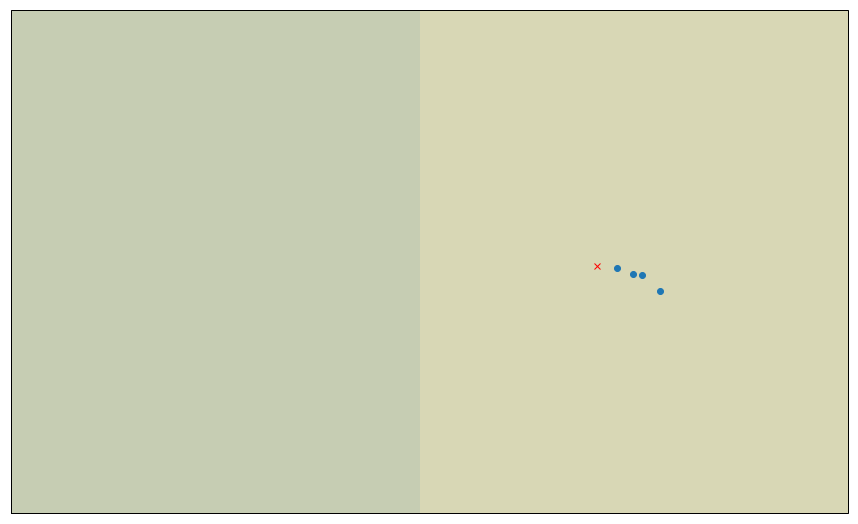

In [221]:
fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_xlim((min_lon, max_lon))
ax.set_ylim((min_lat, max_lat))
plt.plot(st_tst['Longitude'], st_tst['Latitude'], transform=ccrs.PlateCarree(), marker='o', linestyle='')
plt.plot(inc_month.iloc[216]['Longitude'], inc_month.iloc[216]['Latitude'], marker='x', color='red', linestyle='')
# plt.plot(data_inc_d07[data_inc_d07['District']==7]['Longitude'].mean(), data_inc_d07[data_inc_d07['District']==7]['Latitude'].mean()-.05, marker='*', markersize=10, color='black', linestyle='')
plt.show()

In [353]:
srs = pd.read_csv('../data/PeMS/Incidents/test_env/series/smoothed/d07_text_station_5min_2017_03_01.tx.csv', parse_dates=[0])

In [354]:
srs.head()

,Timestamp,Station,District,Freeway,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,Avg Occupancy,Avg Speed
0,2017-03-01 00:20:00,715898,7,5,S,ML,0.430,0,0,86.2,0.01240,68.64
1,2017-03-01 00:20:00,715918,7,5,N,ML,1.075,0,0,91.6,0.01470,68.14
2,2017-03-01 00:20:00,715920,7,5,S,ML,1.290,0,0,156.8,0.03238,64.34
3,2017-03-01 00:20:00,715929,7,5,S,ML,0.470,40,100,161.8,0.04320,63.96
4,2017-03-01 00:20:00,715930,7,5,N,ML,0.505,40,100,134.6,0.03804,66.46


In [107]:
filter_blk_desc('../data/PeMS/Incidents/test_env/det/light/', '../data/PeMS/Incidents/test_env/det/blkg/')

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [162]:
blkg_desc.Timestamp.dt.month.unique()

array([3])

In [108]:
blkg_desc = pd.read_csv('../data/PeMS/Incidents/test_env/det/blkg/all_text_chp_incident_det_month_2017_03.csv', parse_dates=['Timestamp'])

In [112]:
blkg_desc.shape

(5922, 4)

In [62]:
pd.options.display.max_colwidth=120

In [72]:
blkg_desc[blkg_desc.duplicated(subset=['ID'])]

,ID,DetID,Timestamp,Desc


In [7]:
det_day = pd.read_csv('../data/PeMS/Incidents/Batch/light/test/det/all_text_chp_incident_det_day_2017_01_09.csv', parse_dates=['Timestamp'])

In [8]:
det_month.drop(index=det_month[~det_month.ID.isin(det_day.ID)].index, inplace=True)

In [359]:
inc_month = pd.read_csv('../data/PeMS/Incidents/test_env/inc/light/all_text_chp_incident_day_2017_03_01.csv', parse_dates=['Timestamp'])

In [104]:
series = pd.read_csv('../data/PeMS/Series/Batch/light/Jan/smoothed/d07_text_station_5min_2017_01_09.tx.csv', parse_dates=['Timestamp'])

In [105]:
file_stations = '../data/PeMS/Stations/d07_text_meta_2017_01_25.txt'
header_stations = ['ID', 'Freeway', 'Freeway dir', 'Country', 'City', 'State Postmile', 'Abs Postmile', 
          'Latitude', 'Longitude', 'Length', 'Type', 'Lanes', 'Name',
          'User ID1', 'User ID2', 'User ID3', 'User ID4']
stations_active = pd.read_csv(file_stations, sep='\t')
stations_active = stations_active.astype({'Latitude':float, 'Longitude':float})
stations_active = stations_active.dropna(subset=['Latitude', 'Longitude']).reset_index(drop=True)
# result: non-empty speed data series  only, stations which provide these data
stations_active = stations_active[stations_active['ID'].isin(series['Station'].unique())].reset_index(drop=True)
stations_active = stations_active.sort_values('Lanes', ascending=False).drop_duplicates(subset=['Latitude', 'Longitude'], keep='first').sort_index().reset_index(drop=True)

In [107]:
inc_month.head()

,IncidentID,CC_Code,Incident_No,Timestamp,Description,Location,Area,Zoom_Map,TBxy,Latitude,Longitude,District,CountryFIPS_ID,CityFIPS_ID,Freeway,Freeway_direction,State_postmile,Absolute_postmile,Severity,Duration
0,16917037,LAHB,170101,2017-01-01 00:03:00,1125A-Animal Hazard,Sr14 N / Placerita Canyon Rd,Newhall,NaN,NaN,34.377539,-118.493509,7,37.0,44000.0,14,N,R28.088,3.3,NaN,1.0
1,16917042,LAHB,170101,2017-01-01 00:13:00,1125-Traffic Hazard,I405 S / W Rosecrans Ave,West LA,NaN,NaN,33.898375,-118.370277,7,37.0,32548.0,405,S,19.028,42.8,NaN,134.0
2,16917043,LAHB,170101,2017-01-01 00:12:00,1125A-Animal Hazard,Sr118 E / Woodley Ave,West Valley,NaN,NaN,34.267678,-118.484750,7,37.0,44000.0,118,E,R9.069,42.6,NaN,12.0
3,16917044,LAHB,170101,2017-01-01 00:09:00,ANIMAL-Live or Dead Animal,I405 S / Burbank Blvd,West Valley,NaN,NaN,34.172117,-118.467710,7,37.0,44000.0,405,S,40.228,64.0,NaN,65.0
4,16917071,LAHB,170101,2017-01-01 00:37:00,1182-Trfc Collision-No Inj,Sr60 W / Seventh Ave Ofr,Santa Fe Springs,NaN,NaN,34.016738,-117.985385,7,37.0,NaN,60,W,14.559,14.7,NaN,1.0


In [26]:
def get_stations_within_inc_vicinity(incident, stations, vicinity):
    inc_loc = np.asarray(incident[['Latitude', 'Longitude']])
    candidates = stations[(stations['Fwy']==incident['Freeway'])&(stations['Dir']==incident['Freeway_direction'])].drop(stations.columns[-4:], axis=1).copy()
    return candidates[candidates.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), inc_loc).kilometers < vicinity, axis=1)]

In [27]:
def plot_station_data_w_nearest_incds(flow_data, incdnt_data, stations_data, station_no, vicinity_km, chrstc_to_plot = 'Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=flow_data.Timestamp.dt.year.iloc[0], month=flow_data.Timestamp.dt.month.iloc[0], day=flow_data.Timestamp.dt.day.iloc[0], hour=0)
    datemax = dt.datetime(year=flow_data.Timestamp.dt.year.iloc[0], month=flow_data.Timestamp.dt.month.iloc[0], day=flow_data.Timestamp.dt.day.iloc[0], hour=22)
    # filter only data for one station and w/o nans
    data_srs_no_null = flow_data[flow_data['Station'] == station_no]
    data_srs_no_null = data_srs_no_null.dropna(subset=[chrstc_to_plot])
    # station of interest coords
    station_coords = np.asarray(stations_data[stations_data['ID'] == station_no][['Latitude', 'Longitude']])
    # incidents closest to the station
    data_incdnts_nearest = incdnt_data[incdnt_data.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < vicinity_km, axis=1)]
    # x-values
    dates = data_srs_no_null['Timestamp']
    # y-values
    speed = data_srs_no_null[chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for x in data_incdnts_nearest['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

In [362]:
inc_month['Prev'] = inc_month.apply(get_next_wrapper, axis=1, args=(get_next_upstream_station, stations_active))

inc_month.drop(index=inc_month[inc_month.Prev==0].index, inplace=True)

In [21]:
inc_month.drop(columns=['Zoom_Map', 'TBxy', 'CountryFIPS_ID', 'CityFIPS_ID', 'Incident_No', 'Area', 'State_postmile', 'Absolute_postmile'], inplace=True)

In [17]:
test = series[series.Station==716930]

In [314]:
inc_month.Timestamp.iloc[0] #+ dt.timedelta(hours=1)

Timestamp('2017-01-08 21:21:00')

In [316]:
inc_month.Timestamp.iloc[0] - dt.timedelta(hours=1)

Timestamp('2017-01-08 20:21:00')

In [363]:
inc_month.shape

(419, 17)

In [23]:
inc_month[(inc_month.Timestamp.dt.time>=dt.time(hour=1, minute=20)) & (inc_month.Timestamp.dt.hour<23)].shape

(75, 12)

In [32]:
inc_month.drop(index=inc_month[inc_month.Timestamp.dt.hour<1])

ValueError: labels ['IncidentID' 'CC_Code' 'Timestamp' 'Description' 'Location' 'Latitude'
 'Longitude' 'District' 'Freeway' 'Freeway_direction' 'Severity'
 'Duration' 'Next'] not contained in axis

In [34]:
inc_month.iloc[69]

IncidentID                         16936319
CC_Code                                LAHB
Timestamp               2017-01-09 22:00:00
Description             1125-Traffic Hazard
Location             Sr57 N / Pathfinder Rd
Latitude                            33.9843
Longitude                          -117.843
District                                  7
Freeway                                  57
Freeway_direction                         N
Severity                                NaN
Duration                                  1
Next                                 763553
Name: 3462, dtype: object

In [36]:
i=69

test[(test.Timestamp >= inc_month.Timestamp.iloc[i] - dt.timedelta(hours=1)) &  (test.Timestamp < inc_month.Timestamp.iloc[i]+dt.timedelta(hours=1))].shape

(24, 12)

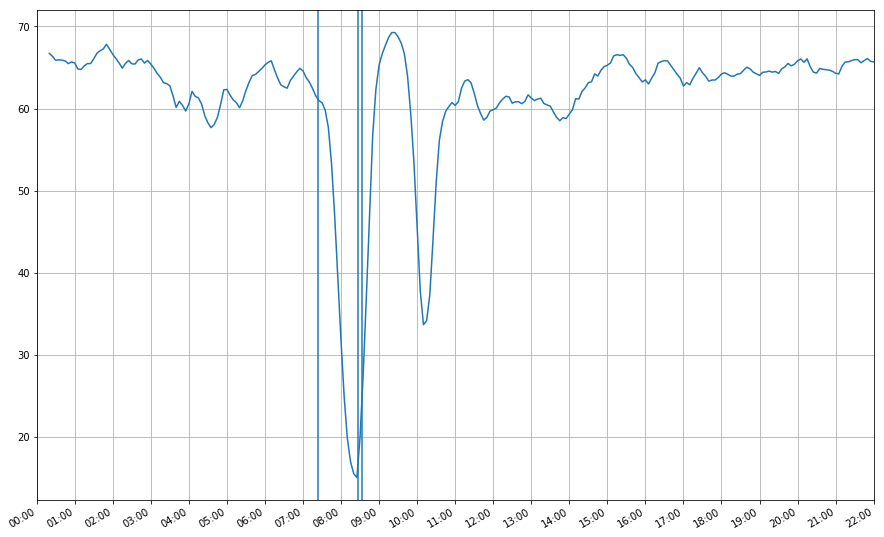

In [244]:
plot_station_data_w_nearest_incds(series, inc_month, stations_active, 717590, 1)

In [118]:
dtypes = {'ID': np.int, 'DetID': np.int, 'Timestamp': datetime, 'Desc': object}

In [121]:
dtypes = {'ID': np.int, 'DetID': np.int}

In [13]:
inc_month.drop(index=inc_month[~inc_month.IncidentID.isin(blkg_desc.ID)].index, inplace=True)

In [194]:
get_stations_within_inc_vicinity(inc_month.iloc[42], stations_active, .4)

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
524,717590,134,W,7,37,30000.0,R8.76,8.743,34.148123,-118.229499,0.405,ML,4,HARVEY


In [14]:
inc_day = pd.read_csv('../data/PeMS/Incidents/Batch/light/test/all_text_chp_incident_day_2017_01_09.csv', parse_dates=['Timestamp'])
det_header = ['ID', 'DetID', 'Timestamp', 'Desc']
det_day = pd.read_csv('../data/PeMS/Incidents/Batch/light/test/all_text_chp_incident_det_day_2017_01_09.csv', parse_dates=['Timestamp']) #, names=det_header)#, skip_blank_lines=False, sep=',', error_bad_lines=True)

In [66]:
inc_month = pd.read_csv('../data/PeMS/Incidents/Batch/light/test/all_text_chp_incidents_month_2017_01.csv', parse_dates=['Timestamp'])
det_month = pd.read_csv('../data/PeMS/Incidents/Batch/light/test/all_text_chp_incident_det_month_2017_01.csv', parse_dates=['Timestamp'])

incdnt_det_file_name = '../data/PeMS/Incidents/Batch/2017/test/all_text_chp_incident_det_day_2017_01_09.txt'
det_header = ['ID', 'DetID', 'Timestamp', 'Desc']
det_day = pd.read_csv(incdnt_det_file_name, sep=',', names=det_header, parse_dates=[2])

det_day.to_csv('../data/PeMS/Incidents/Batch/light/test/all_text_chp_incident_det_day_2017_01_09.csv', index=False)

In [84]:
incdnt_det_file_name = '../data/PeMS/Incidents/Batch/2017/test/det/all_text_chp_incident_det_month_2017_01.txt'
det_header = ['ID', 'DetID', 'Timestamp', 'Desc']
det_month = pd.read_csv(incdnt_det_file_name, sep=',', names=det_header, parse_dates=[2])

#det_month.to_csv('../data/PeMS/Incidents/Batch/light/test/all_text_chp_incident_det_month_2017_01.csv', index=False)

In [5]:
inc_month_day = inc_month[inc_month.Timestamp.dt.date == inc_day.Timestamp.dt.date[0]]

In [58]:
det_month_day = det_month[det_month.Timestamp.dt.date == det_day.Timestamp.dt.date[0]]

In [64]:
det_month_day = det_month[det_month.ID.isin(inc_day.IncidentID)]

In [15]:
inc_month.shape

(75, 20)

In [23]:
inc_day.shape

(501, 20)

In [65]:
det_month_day.shape

(0, 4)

In [76]:
det_month[det_month.ID.isin(inc_day.IncidentID)]

,ID,DetID,Timestamp,Desc


In [79]:
det_month.dtypes

ID                   object
DetID               float64
Timestamp    datetime64[ns]
Desc                 object
dtype: object

In [74]:
det_month.shape

(711322, 4)

In [27]:
det_day[~det_day.DetID.isna()].shape

(25407, 4)

In [29]:
det_day[det_day.DetID.isna()].shape

(127, 4)

In [32]:
det_month_day.to_csv('../data/PeMS/Incidents/Batch/light/test/all_text_chp_incident_det_month_day_2017_01_09.csv', index=False)

In [60]:
det_month_day.ID.unique().shape

(2473,)

In [35]:
d7_inc_day = inc_day[inc_day.District == 7]

In [39]:
inc_day.columns

Index(['IncidentID', 'CC_Code', 'Incident_No', 'Timestamp', 'Description',
       'Location', 'Area', 'Zoom_Map', 'TBxy', 'Latitude', 'Longitude',
       'District', 'CountryFIPS_ID', 'CityFIPS_ID', 'Freeway',
       'Freeway_direction', 'State_postmile', 'Absolute_postmile', 'Severity',
       'Duration'],
      dtype='object')

In [40]:
det_month_day.drop(index=det_month_day[~det_month_day.ID.isin(inc_day.IncidentID)].index, inplace=True)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
det_month_day[det_month_day.ID.isin(inc_day.IncidentID)].head()

,ID,DetID,Timestamp,Desc


In [69]:
inc_month[inc_month.IncidentID==16933993]

,IncidentID,CC_Code,Incident_No,Timestamp,Description,Location,Area,Zoom_Map,TBxy,Latitude,Longitude,District,CountryFIPS_ID,CityFIPS_ID,Freeway,Freeway_direction,State_postmile,Absolute_postmile,Severity,Duration


In [71]:
inc_day.head()

,IncidentID,CC_Code,Incident_No,Timestamp,Description,Location,Area,Zoom_Map,TBxy,Latitude,Longitude,District,CountryFIPS_ID,CityFIPS_ID,Freeway,Freeway_direction,State_postmile,Absolute_postmile,Severity,Duration
0,16934010,LAHB,170109,2017-01-09 00:09:00,FIRE-Report of Fire,Us101 S / Melrose Ave,Central LA,NaN,NaN,34.083554,-118.298805,7,37.0,44000.0,101,S,4.852,6.2,NaN,1.0
1,16934015,LAHB,170109,2017-01-09 00:15:00,1125-Traffic Hazard,I5 N / Indiana St,East LA,NaN,NaN,34.020302,-118.192255,7,37.0,NaN,5,N,14.967,131.6,NaN,44.0
2,16934022,LAHB,170109,2017-01-09 00:19:00,1125-Traffic Hazard,I5 N / N Broadway,Central LA,NaN,NaN,34.073061,-118.219156,7,37.0,44000.0,5,N,19.767,136.4,NaN,15.0
3,16934023,LAHB,170109,2017-01-09 00:18:00,1183-Trfc Collision-Unkn Inj,SR118 E / I5 S SR118 CON,West Valley,NaN,NaN,34.268062,-118.435692,7,37.0,44000.0,118,E,R11.869,45.4,NaN,35.0
4,16934043,LAHB,170109,2017-01-09 00:39:00,WW-Wrong Way Driver,I710 N / W Broadway,South LA,NaN,NaN,33.769589,-118.207113,7,37.0,43000.0,710,N,5.46,0.5,NaN,2.0
